In [1]:
from plots.mpltoolkit import named_colors, mpl_loc, markers, fancy_legend, load_style_sheet
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from scipy.stats import linregress
import numpy as np
import random
import vice
import sys
sys.path.append("..")
from src.stats import skewnormal_mode_sample, jackknife_summary_statistic
load_style_sheet("papers")
# load_mpl_presets()
# mpl.rcParams["axes.linewidth"] = 0.5
# mpl.rcParams["figure.titlesize"] = 14
# mpl.rcParams["axes.titlesize"] = 14
# mpl.rcParams["axes.labelsize"] = 14
# mpl.rcParams["xtick.labelsize"] = 14
# mpl.rcParams["ytick.labelsize"] = 14
# mpl.rcParams["legend.fontsize"] = 14
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=13, releaselevel='final', serial=0)


In [2]:
# outputs = [
#     "../outputs/inside-out/eta-0/lowyields",
#     "../outputs/inside-out/eta-0p4/lowyields",
#     "../outputs/inside-out/eta-eR/lowyields",
#     "../outputs/inside-out/eta-eR/highyields"
# ]
outputs = [
    "../outputs/inside-out/eta-0/yieldsolar1",
    "../outputs/inside-out/eta-0p4/yieldsolar1",
    "../outputs/inside-out/eta-eR/yieldsolar1",
    "../outputs/inside-out/eta-eR/yieldsolar3"
]
outputs = [vice.output(_) for _ in outputs]
for out in outputs:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:, -1][:out.stars.size[0]]]

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_49342/878809818.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


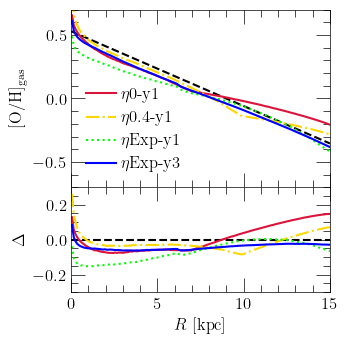

In [3]:
ZONE_WIDTH = 0.1
COLORS = ["crimson", "gold", "lime", "blue"]
LINESTYLES = ["-", "-.", ":", "-"]
LABELS = [
    r"$\eta$0-y1",
    r"$\eta$0.4-y1",
    r"$\eta$Exp-y1",
    r"$\eta$Exp-y3"
]

fig = plt.figure()
top = fig.add_subplot(111)
bottom = fig.add_axes([0.1, 0.1, 0.8, 0.3], sharex = top)
plt.setp(top.get_xticklabels(), visible = False)
bottom.set_xlabel(r"$R$ [kpc]")
top.set_ylabel(r"[O/H]$_\text{gas}$")
bottom.set_ylabel(r"$\Delta$")
top.set_xlim([0, 15])
top.set_ylim([-0.7, 0.7])
bottom.set_ylim([-0.3, 0.3])

def reference_gradient(radius, slope = -0.059, intercept = 0.53):
    # slope and intercept taken from Mendez-Delgado et al. (2022)
    return intercept + slope * radius

def plot_predicted_gradient(ax1, ax2, output, **kwargs):
    radii = [ZONE_WIDTH * (i + 0.5) for i in range(len(output.zones.keys()))]
    oh = []
    for i in range(len(radii)): oh.append(output.zones["zone%d" % (i)].history["[o/h]"][-1])
    ax1.plot(radii, oh, **kwargs)
    delta = []
    for i in range(len(radii)): delta.append(oh[i] - reference_gradient(radii[i]))
    ax2.plot(radii, delta, **kwargs)

top.plot(top.get_xlim(), [reference_gradient(x) for x in top.get_xlim()],
    c = named_colors()["black"], linestyle = "--")
bottom.axhline(0, c = named_colors()["black"], linestyle = "--")
for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": LINESTYLES[i],
        "label": LABELS[i]
    }
    plot_predicted_gradient(top, bottom, outputs[i], **kwargs)

kwargs = {
    "loc": mpl_loc("lower left"),
    "ncol": 1,
    "handlelength": 1.8
}
leg = top.legend(**kwargs)

plt.tight_layout()
plt.subplots_adjust(hspace = 0)
split = 0.45
top.set_position([
    top.get_position().x0,
    split,
    top.get_position().x1 - top.get_position().x0,
    top.get_position().y1 - split
])
bottom.set_position([
    top.get_position().x0,
    0.15,
    top.get_position().x1 - top.get_position().x0,
    split - 0.15
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./eq-vs-subeq/grad-oh-gas-calibration.%s" % (ext), **kwargs)
plt.show()

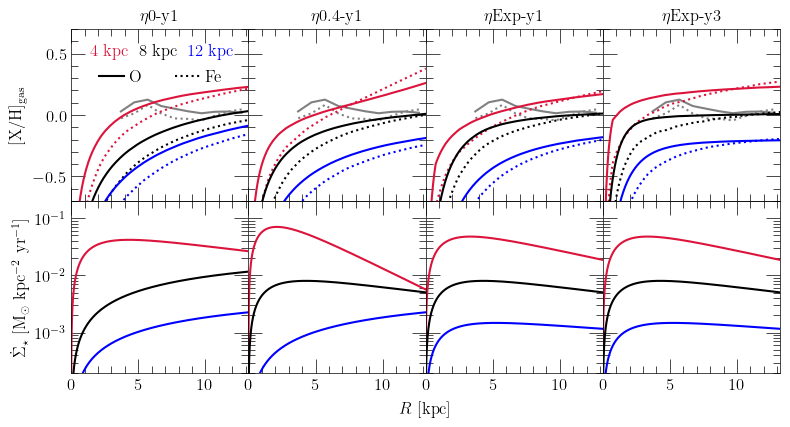

In [4]:
RADII = [4, 8, 12]
COLORS = ["crimson", "black", "blue"]
ZONE_WIDTH = 0.1
TITLES = [
    r"$\eta$0-y1",
    r"$\eta$0.4-y1",
    r"$\eta$Exp-y1",
    r"$\eta$Exp-y3"
]

fig = plt.figure(figsize = (8, 4.3))
top = []
bottom = []
for i in range(4):
    kwargs = {}
    if i:
        kwargs["sharex"] = bottom[0]
        kwargs["sharey"] = bottom[0]
    bottom.append(fig.add_subplot(245 + i, **kwargs))
    bottom[i].set_yscale("log")
    kwargs["sharex"] = bottom[i]
    if i: kwargs["sharey"] = top[0]
    top.append(fig.add_subplot(241 + i, **kwargs))
    top[i].set_title(TITLES[i], fontsize = 12)
    plt.setp(top[i].get_xticklabels(), visible = False)
    if i:
        plt.setp(top[i].get_yticklabels(), visible = False)
        plt.setp(bottom[i].get_yticklabels(), visible = False)
    else:
        top[i].set_ylabel(r"[X/H]$_\text{gas}$")
        bottom[i].set_ylabel(r"$\dot{\Sigma}_\star$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
bottom[0].set_xlim([0, 13.2])
bottom[0].set_xticks([0, 5, 10])
bottom[0].set_ylim([2e-4, 0.2])
top[0].set_ylim([-0.7, 0.7])
background_ax = fig.add_subplot(111, xticks = [], yticks = [], frameon = False)
background_ax.set_xlabel(r"$R$ [kpc]", labelpad = 20)

line1 = top[0].plot([1, 2], [1, 2], c = named_colors()["black"], linestyle = "-", label = "O")[0]
line2 = top[0].plot([1, 2], [1, 2], c = named_colors()["black"], linestyle = ":", label = "Fe")[0]
kwargs = {
    "loc": mpl_loc("upper center"),
    "bbox_to_anchor": (0.5, 0.85),
    "handlelength": 1.5,
    "ncol": 2
}
leg = top[0].legend(**kwargs)
line1.remove()
line2.remove()
top[0].add_artist(leg)

def plot_observed_modes(ax, disk_lifetime = 13.2, **kwargs):
    # values taken from Table 1 of the paper draft
    mode_oh = [0.018, 0.028, 0.026, 0.014, 0.030, 0.051, 0.073, 0.125, 0.103, 0.029]
    mode_oh_err = [0.022, 0.013, 0.016, 0.012, 0.012, 0.021, 0.025, 0.007, 0.030, 0.018]
    mode_feh = [0.045, 0.028, -0.006, -0.044, -0.032, -0.028, 0.012, 0.082, 0.013, -0.027]
    mode_feh_err = [0.020, 0.014, 0.017, 0.015, 0.020, 0.035, 0.036, 0.014, 0.031, 0.022]
    ages = [0.5 + i for i in range(10)]
    xvals = [disk_lifetime - _ for _ in ages]
    ax.plot(xvals, mode_oh, **kwargs)
    ax.plot(xvals, mode_feh, linestyle = ":", **kwargs)

def plot_model(ax_xh, ax_sfh, output, radius, **kwargs):
    zone = int(radius / ZONE_WIDTH)
    zone = output.zones["zone%d" % (zone)]
    area = np.pi * ((radius + ZONE_WIDTH)**2 - radius**2)
    sigma_sfh = [sfr / area for sfr in zone.history["sfr"]]
    time = zone.history["time"]
    oh = zone.history["[o/h]"]
    feh = zone.history["[fe/h]"]
    ax_sfh.plot(time, sigma_sfh, **kwargs)
    ax_xh.plot(time, oh, **kwargs)
    kwargs["label"] = None
    ax_xh.plot(time, feh, linestyle = ":", **kwargs)

for i in range(len(outputs)):
    plot_observed_modes(top[i], c = named_colors()["grey"])
    for j in range(len(RADII)):
        kwargs = {
            "c": named_colors()[COLORS[j]],
            "label": r"$%d$ kpc" % (RADII[j])
        }
        plot_model(top[i], bottom[i], outputs[i], RADII[j], **kwargs)

kwargs = {
    "loc": mpl_loc("upper center"),
    "handlelength": 0,
    "ncol": 3,
    "columnspacing": 0.3
}
leg = top[0].legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0, bottom = 0.12)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./eq-vs-subeq/allmodels-evol.%s" % (ext), **kwargs)
plt.show()

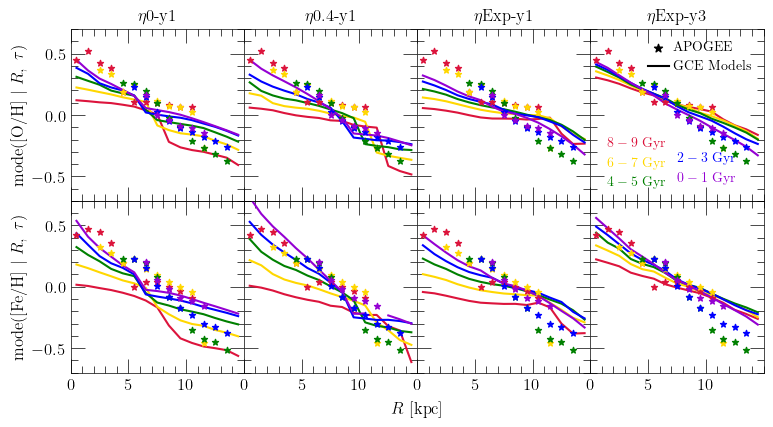

In [14]:
RADIAL_BINS = list(range(16))
AGE_RANGES = [[8, 9], [6, 7], [4, 5], [2, 3], [0, 1]]
# COLORS = ["darkviolet", "blue", "green", "gold", "crimson"]
# AGE_RANGES = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
COLORS = ["crimson", "gold", "green", "blue", "darkviolet"]
ZONE_WIDTH = 0.1
TITLES = [
    r"$\eta$0-y1",
    r"$\eta$0.4-y1",
    r"$\eta$Exp-y1",
    r"$\eta$Exp-y3"
]

fig = plt.figure(figsize = (8, 4.3))
top = []
bottom = []
for i in range(4):
    kwargs = {}
    if i:
        kwargs["sharex"] = bottom[0]
        kwargs["sharey"] = bottom[0]
    bottom.append(fig.add_subplot(245 + i, **kwargs))
    kwargs["sharex"] = bottom[i]
    if i: kwargs["sharey"] = top[0]
    top.append(fig.add_subplot(241 + i, **kwargs))
    top[i].set_title(TITLES[i], fontsize = 12)
    plt.setp(top[i].get_xticklabels(), visible = False)
    if i:
        plt.setp(top[i].get_yticklabels(), visible = False)
        plt.setp(bottom[i].get_yticklabels(), visible = False)
    else:
        top[i].set_ylabel(r"mode([O/H] $|\ R,\ \tau$)")
        bottom[i].set_ylabel(r"mode([Fe/H] $|\ R,\ \tau$)")
bottom[0].set_xlim([0, 15])
bottom[0].set_xticks([0, 5, 10])
bottom[0].set_ylim([-0.7, 0.7])
top[0].set_ylim([-0.7, 0.7])
background_ax = fig.add_subplot(111, xticks = [], yticks = [], frameon = False)
background_ax.set_xlabel(r"$R$ [kpc]", labelpad = 20)

line1 = top[3].scatter([1, 2], [1, 2], c = named_colors()["black"], marker = markers()["star"], label = "APOGEE")
line2 = top[3].plot([1, 2], [1, 2], c = named_colors()["black"], label = "GCE Models")[0]
kwargs = {
    "loc": mpl_loc("upper right"),
    "handlelength": 1.5,
    "fontsize": 10
}
leg = top[3].legend(**kwargs)
line1.remove()
line2.remove()
top[3].add_artist(leg)

def plot_data(ax, element, filename = "./empirical/skewnormfits-binned-by-age-and-radius.out"):
    raw = np.genfromtxt(filename)
    for i, age_range in enumerate(AGE_RANGES):
        xvals = []
        yvals = []
        for row in raw:
            if row[0] == age_range[0] and row[1] == age_range[1]:
                xvals.append((row[2] + row[3]) / 2)
                yvals.append(row[4 + 2 * int(element.lower() == "fe")])
            else: pass
        kwargs = {
            "c": named_colors()[COLORS[i]],
            "marker": markers()["star"],
            "s": 20,
            "zorder": 100
        }
        ax.scatter(xvals, yvals, **kwargs)

def plot_model(ax, element, filename):
    raw = np.genfromtxt(filename)
    for i in range(len(AGE_RANGES)):
        xvals = []
        yvals = []
        for j in range(len(raw)):
            if raw[j][0] == AGE_RANGES[i][0] and raw[j][1] == AGE_RANGES[i][1]:
                xvals.append((raw[j][2] + raw[j][3]) / 2)
                yvals.append(raw[j][{"o": 4, "fe": 5}[element.lower()]])
            else: continue
        kwargs = {
            "c": named_colors()[COLORS[i]],
            "label": r"$%d - %d$ Gyr" % (AGE_RANGES[i][0], AGE_RANGES[i][1]),
            "zorder": 50
        }
        ax.plot(xvals, yvals, **kwargs)

for i in range(len(outputs)):
    plot_data(top[i], "O")
    plot_data(bottom[i], "Fe")
    plot_model(top[i], "O", "%s-modexh-binned-by-age-and-radius.out" % (outputs[i].name))
    plot_model(bottom[i], "Fe", "%s-modexh-binned-by-age-and-radius.out" % (outputs[i].name))

kwargs = {
    "loc": mpl_loc("lower left"),
    "ncol": 2,
    "handlelength": 0,
    "columnspacing": 0.5,
    "fontsize": 10
}
leg = top[3].legend(**kwargs)
fancy_legend(leg, COLORS)
for i in range(len(AGE_RANGES))[-2:]:
    renderer = fig.canvas.get_renderer()
    y_shift = -1.2 * leg.texts[i].get_window_extent(renderer).height
    leg.texts[i].set_position((0, y_shift))

plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0, bottom = 0.12)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./eq-vs-subeq/allmodels-gradxh-agebins.%s" % (ext), **kwargs)
plt.show()

In [7]:
def boxcarsmoothdist(arr, window = 5, **kwargs):
    dist, bins = np.histogram(arr, **kwargs)
    yvals = len(dist) * [0.]
    for i in range(len(yvals)):
        start = max(0, i - window)
        stop = min(i + window, len(yvals))
        yvals[i] = np.mean(dist[start:stop])
    centers = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    return [centers, yvals]

0 - 1 Gyr    
0 - 1 Gyr    
0 - 1 Gyr    
0 - 1 Gyr    


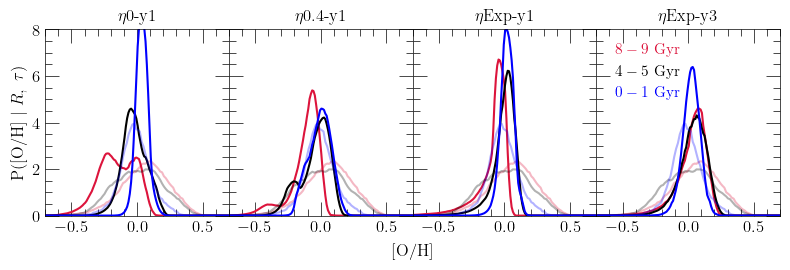

In [8]:
ELEMENT = "O"
# AGE_BINS = [[8, 9], [6, 7], [4, 5], [2, 3], [0, 1]]
# COLORS = ["crimson", "gold", "green", "blue", "darkviolet"]
AGE_BINS = [[8, 9], [4, 5], [0, 1]]
COLORS = ["crimson", "black", "blue"]
RGAL_MIN = 7 # kpc
RGAL_MAX = 9 # kpc
ZONE_WIDTH = 0.1 # kpc
TITLES = [
    r"$\eta$0-y1",
    r"$\eta$0.4-y1",
    r"$\eta$Exp-y1",
    r"$\eta$Exp-y3"
]

fig = plt.figure(figsize = (8, 3))
axes = []
for i in range(4):
    kwargs = {}
    if i:
        kwargs["sharex"] = axes[0]
        kwargs["sharey"] = axes[0]
    else: pass
    axes.append(fig.add_subplot(141 + i, **kwargs))
    axes[i].set_title(TITLES[i])
    if i:
        plt.setp(axes[i].get_yticklabels(), visible = False)
    else:
        axes[i].set_ylabel(r"P([%s/H] $|\ R,\ \tau$)" % (ELEMENT.capitalize()))
axes[0].set_xlim([-0.7, 0.7])
axes[0].set_ylim([0, 8])
shadow_ax = fig.add_subplot(111, xticks = [], yticks = [], frameon = False)
shadow_ax.set_xlabel(r"[%s/H]" % (ELEMENT.capitalize()), labelpad = 20)

def plot_observed_distribution(ax, age_min, age_max,
    filename = "./empirical/solar-annulus-%sh-dists-agebins.out" % (ELEMENT.lower()), **kwargs):
    raw = np.genfromtxt(filename)
    xvals = []
    yvals = []
    for i in range(len(raw)):
        if raw[i][0] == age_min and raw[i][1] == age_max:
            xvals.append(raw[i][2])
            yvals.append(raw[i][3])
        else: pass
    ax.plot(xvals, yvals, **kwargs)

def plot_predicted_distribution(ax, output, age_min, age_max, **kwargs):
    stars = output.stars.filter(
        "age", ">=", age_min).filter(
        "age", "<=", age_max).filter(
        "zone_final", ">=", int(RGAL_MIN / ZONE_WIDTH)).filter(
        "zone_final", "<=", int(RGAL_MAX / ZONE_WIDTH) - 1).filter(
        "absz", "<=", 0.5).filter(
        "mass", ">=", 1)
    xvals, yvals = boxcarsmoothdist(stars["[%s/h]" % (ELEMENT)], bins = np.arange(-3, 2, 0.01),
        density = True, weights = stars["mass"])
    ax.plot(xvals, yvals, **kwargs)

for i in range(len(outputs)):
    for j in range(len(AGE_BINS)):
        sys.stdout.write("\r%d - %d Gyr    " % (AGE_BINS[j][0], AGE_BINS[j][1]))
        kwargs = {
            "c": named_colors()[COLORS[j]],
            "label": r"$%d - %d$ Gyr" % (AGE_BINS[j][0], AGE_BINS[j][1])
        }
        plot_predicted_distribution(axes[i], outputs[i], AGE_BINS[j][0], AGE_BINS[j][1], **kwargs)
        kwargs["label"] = None
        kwargs["alpha"] = 0.3
        plot_observed_distribution(axes[i], AGE_BINS[j][0], AGE_BINS[j][1], **kwargs)
    sys.stdout.write("\n")

kwargs = {
    "loc": mpl_loc("upper left"),
    "ncol": 1,
    "handlelength": 0,
    "fontsize": 11
}
leg = axes[3].legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(wspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./eq-vs-subeq/solar-annulus-%sh-dists-datacomp.%s" % (ELEMENT.lower(), ext), **kwargs)
plt.show()

11 - 13 kpc    
11 - 13 kpc    
11 - 13 kpc    
11 - 13 kpc    


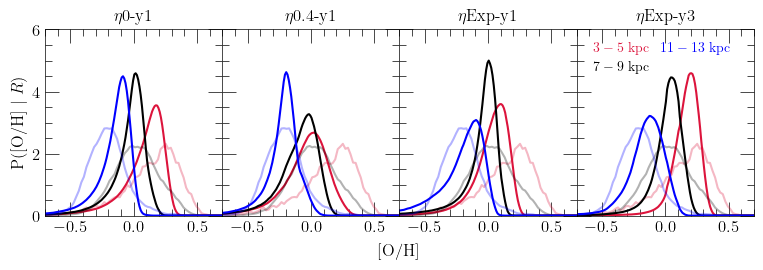

In [10]:
ELEMENT = "O"
# RADIAL_BINS = [3, 5, 7, 9, 11, 13]
# COLORS = ["crimson", "gold", "green", "blue", "darkviolet"]
RADIAL_BINS = [[3, 5], [7, 9], [11, 13]]
COLORS = ["crimson", "black", "blue"]
ZONE_WIDTH = 0.1
TITLES = [
    r"$\eta$0-y1",
    r"$\eta$0.4-y1",
    r"$\eta$Exp-y1",
    r"$\eta$Exp-y3"
]

fig = plt.figure(figsize = (8, 3))
axes = []
for i in range(4):
    kwargs = {}
    if i:
        kwargs["sharex"] = axes[0]
        kwargs["sharey"] = axes[0]
    else: pass
    axes.append(fig.add_subplot(141 + i, **kwargs))
    axes[i].set_title(TITLES[i])
    if i:
        plt.setp(axes[i].get_yticklabels(), visible = False)
    else:
        axes[i].set_ylabel(r"P([%s/H] $|\ R$)" % (ELEMENT.capitalize()))
axes[0].set_xlim([-0.7, 0.7])
axes[0].set_ylim([0, 6])
shadow_ax = fig.add_subplot(111, xticks = [], yticks = [], frameon = False)
shadow_ax.set_xlabel(r"[%s/H]" % (ELEMENT.capitalize()), labelpad = 20)

def plot_observed_distribution(ax, rgal_min, rgal_max,
    filename = "./empirical/%sh-dists.out" % (ELEMENT.lower()), **kwargs):
    raw = np.genfromtxt(filename)
    xvals = []
    yvals = []
    for i in range(len(raw)):
        if raw[i][0] == rgal_min and raw[i][1] == rgal_max:
            xvals.append(raw[i][2])
            yvals.append(raw[i][3])
        else: pass
    ax.plot(xvals, yvals, **kwargs)

def plot_predicted_distribution(ax, output, rgal_min, rgal_max, **kwargs):
    stars = output.stars.filter(
        "zone_final", ">=", int(rgal_min / ZONE_WIDTH)).filter(
        "zone_final", "<=", int(rgal_max / ZONE_WIDTH) - 1).filter(
        "absz", "<=", 0.5).filter(
        "mass", ">=", 1)
    xvals, yvals = boxcarsmoothdist(stars["[%s/h]" % (ELEMENT)], bins = np.arange(-3, 2, 0.01),
        density = True, weights = stars["mass"])
    ax.plot(xvals, yvals, **kwargs)

for i in range(len(outputs)):
    for j in range(len(RADIAL_BINS)):
        sys.stdout.write("\r%d - %d kpc    " % (RADIAL_BINS[j][0], RADIAL_BINS[j][1]))
        kwargs = {
            "c": named_colors()[COLORS[j]],
            "label": r"$%d - %d$ kpc" % (RADIAL_BINS[j][0], RADIAL_BINS[j][1])
        }
        plot_predicted_distribution(axes[i], outputs[i], RADIAL_BINS[j][0], RADIAL_BINS[j][1], **kwargs)
        kwargs["label"] = None
        kwargs["alpha"] = 0.3
        plot_observed_distribution(axes[i], RADIAL_BINS[j][0], RADIAL_BINS[j][1], **kwargs)
    sys.stdout.write("\n")

kwargs = {
    "loc": mpl_loc("upper left"),
    "ncol": 2,
    "handlelength": 0,
    "fontsize": 10,
    "columnspacing": 0.5
}
leg = axes[3].legend(**kwargs)
fancy_legend(leg, COLORS)
 
plt.tight_layout()
plt.subplots_adjust(wspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./eq-vs-subeq/%sh-distributions-radbins.%s" % (ELEMENT.lower(), ext), **kwargs)
plt.show()

0 [o/h]
0 [fe/h]
0 [o/fe]
1 [o/h]
1 [fe/h]
1 [o/fe]
2 [o/h]
2 [fe/h]
2 [o/fe]
3 [o/h]
3 [fe/h]
3 [o/fe]


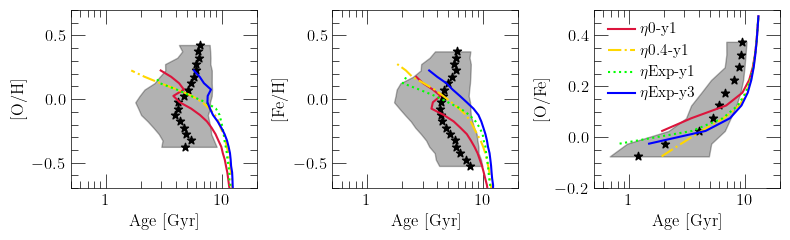

In [25]:
LABELS = [
    r"$\eta$0-y1",
    r"$\eta$0.4-y1",
    r"$\eta$Exp-y1",
    r"$\eta$Exp-y3"
]
COLORS = ["crimson", "gold", "lime", "blue"]
LINESTYLES = ["-", "-.", ":", "-"]

fig = plt.figure(figsize = (8, 2.5))
axes = []
for i in range(3):
    axes.append(fig.add_subplot(131 + i))
    axes[i].set_xlabel(r"Age [Gyr]")
    axes[i].set_xscale("log")
    axes[i].set_xlim([0.5, 20])
    axes[i].xaxis.set_major_formatter(fsf("%g"))
axes[0].set_ylabel(r"[O/H]")
axes[0].set_ylim([-0.7, 0.7])
axes[1].set_ylabel(r"[Fe/H]")
axes[1].set_ylim([-0.7, 0.7])
axes[2].set_ylabel("[O/Fe]")
axes[2].set_ylim([-0.2, 0.5])

def plot_observed_amr(ax, filename, **kwargs):
    raw = np.genfromtxt(filename)
    centers = [(a + b) / 2 for a, b in zip(raw[:, 0], raw[:, 1])]
    # kwargs = {
    #     "color": named_colors()["grey"],
    #     "marker": None,
    #     "linestyle": "None",
    #     "capsize": 1,
    #     "xerr": [
    #         [m - l for m, l in zip(raw[:, 3], raw[:, 2])],
    #         [u - m for u, m in zip(raw[:, 4], raw[:, 3])]
    #     ],
    #     "zorder": 1
    # }
    # ax.errorbar(raw[:, 3], centers, **kwargs)
    kwargs = {
        "color": named_colors()["black"],
        "alpha": 0.3
    }
    ax.fill_betweenx(centers, raw[:, 2], raw[:, 4], **kwargs)
    kwargs = {
        "c": named_colors()["black"],
        "marker": markers()["star"],
        "zorder": 2
    }
    ax.scatter(raw[:, 3], centers, **kwargs)

def plot_predicted_amr(ax, stars, key, min_rgal = 7, max_rgal = 9, zone_width = 0.1,
    bins = np.arange(-3, 1, 0.05), **kwargs):
    # lower, median, upper = get_predicted_amr(stars, key, min_rgal = min_rgal,
        # max_rgal = max_rgal, zone_width = zone_width, bins = bins)
    ages = get_predicted_amr(stars, key, min_rgal = min_rgal,
        max_rgal = max_rgal, zone_width = zone_width, bins = bins)
    centers = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    ax.plot(ages, centers, **kwargs)
    # ax.plot(median, centers, **kwargs)
    # kwargs["linestyle"] = ":"
    # if "label" in kwargs.keys(): kwargs["label"] = None
    # ax.plot(lower, centers, **kwargs)
    # ax.plot(upper, centers, **kwargs)

def get_predicted_amr(stars, key, min_rgal = 7, max_rgal = 9, zone_width = 0.1,
    bins = np.arange(-3, 1, 0.05)):
    stars = stars.filter(
        "zone_final", ">=", int(min_rgal / zone_width)).filter(
        "zone_final", "<=", int(max_rgal / zone_width)).filter(
        "absz", "<=", 0.5).filter(
        "mass", ">=", 1)
    # lower = (len(bins) - 1) * [None]
    # median = (len(bins) - 1) * [None]
    # upper = (len(bins) - 1) * [None]
    ages = (len(bins) - 1) * [None]
    for i in range(len(bins) - 1):
        sub = stars.filter(
            key, ">=", bins[i]).filter(
            key, "<=", bins[i + 1])
        if len(sub["age"]) > 10:
            indeces = np.argsort(sub["age"])
            norm = 0
            for idx in indeces: norm += sub["age"][idx] * sub["mass"][idx]
            s = 0
            for idx in indeces:
                s += sub["age"][idx] * sub["mass"][idx] / norm
                if s > 0.5 and ages[i] is None:
                    ages[i] = sub["age"][idx]
                    break
                else: pass
        else:
            ages[i] = float("nan")
    return ages
    #     if len(sub["age"]) > 20:
    #         indeces = np.argsort(sub["age"])
    #         norm = 0
    #         for idx in indeces: norm += sub["age"][idx] * sub["mass"][idx]
    #         s = 0
    #         for idx in indeces:
    #             s += sub["age"][idx] * sub["mass"][idx] / norm
    #             if s > 0.16 and lower[i] is None: lower[i] = sub["age"][idx]
    #             if s > 0.5 and median[i] is None: median[i] = sub["age"][idx]
    #             if s > 0.84 and upper[i] is None: upper[i] = sub["age"][idx]
    #     else:
    #         lower[i] = float("nan")
    #         median[i] = float("nan")
    #         upper[i] = float("nan")
    # return [lower, median, upper]

plot_observed_amr(axes[0], "./empirical/amr-7-9-o_h.out")
plot_observed_amr(axes[1], "./empirical/amr-7-9-fe_h.out")
plot_observed_amr(axes[2], "./empirical/amr-7-9-o_fe.out")

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": LINESTYLES[i],
        "label": LABELS[i]
    }
    print(i, "[o/h]")
    plot_predicted_amr(axes[0], outputs[i].stars, "[o/h]", **kwargs)
    print(i, "[fe/h]")
    plot_predicted_amr(axes[1], outputs[i].stars, "[fe/h]", **kwargs)
    print(i, "[o/fe]")
    plot_predicted_amr(axes[2], outputs[i].stars, "[o/fe]", **kwargs)

kwargs = {
    "loc": mpl_loc("upper left"),
    "ncol": 1,
    "handlelength": 1.8,
    "fontsize": 11
}
axes[2].legend(**kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./eq-vs-subeq/solar-annulus-amr-datacomp.%s" % (ext), **kwargs)
plt.show()

In [2]:
eq = vice.output("../outputs/inside-out/vrad0")
subeq = vice.output("../outputs/simplified/expsfh-eta0")
for out in [eq, subeq]:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:,-1][:out.stars.size[0]]]
eq_stars = eq.stars.filter("absz", "<=", 0.5)
subeq_stars = subeq.stars.filter("absz", "<=", 0.5)

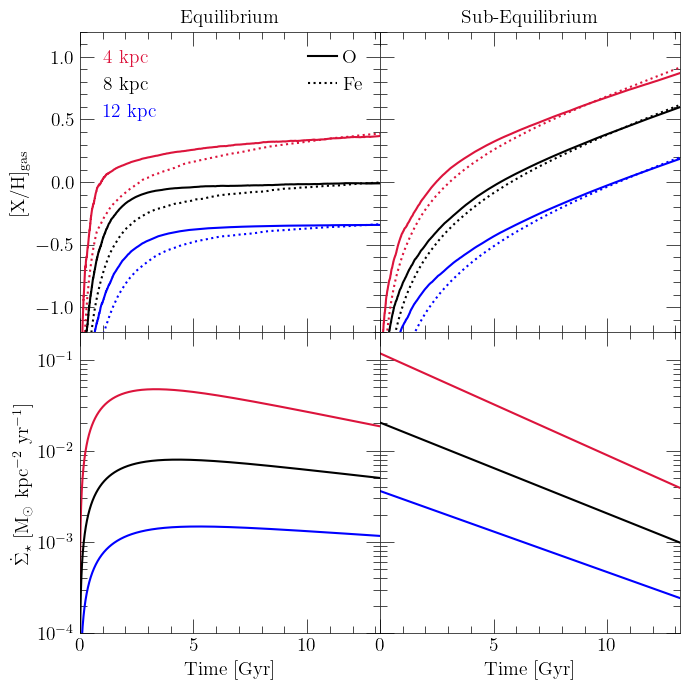

In [13]:
# RADII = [3, 5, 7, 9, 11, 13]
# COLORS = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]
RADII = [4, 8, 12]
COLORS = ["crimson", "black", "blue"]
ZONE_WIDTH = 0.1

fig = plt.figure(figsize = (7, 7))
axes = []
for i in range(4):
    kwargs = {}
    if i: kwargs["sharex"] = axes[0]
    if i % 2: kwargs["sharey"] = axes[i - 1]
    else: pass
    axes.append(fig.add_subplot(221 + i, **kwargs))
    axes[i].set_xlim([0, 13.2])
    if i % 2: plt.setp(axes[i].get_yticklabels(), visible = False)
    if i < 2:
        plt.setp(axes[i].get_xticklabels(), visible = False)
        # axes[i].set_yscale("log")
    else:
        axes[i].set_xlabel("Time [Gyr]")
        axes[i].set_yscale("log")
axes[0].set_ylabel(r"[X/H]$_\text{gas}$")
axes[0].set_ylim([-1.2, 1.2])
axes[0].set_title("Equilibrium")
axes[1].set_title("Sub-Equilibrium")
axes[2].set_ylabel(r"$\dot{\Sigma}_\star$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
axes[2].set_ylim([1.e-4, 0.2])

line1 = axes[0].plot([-1, -2], [-1, -2], c = named_colors()["black"], linestyle = "-", label = "O")[0]
line2 = axes[0].plot([-1, -2], [-1, -2], c = named_colors()["black"], linestyle = ":", label = "Fe")[0]
kwargs = {
    "loc": mpl_loc("upper right"),
    "handlelength": 1.5
}
leg = axes[0].legend(**kwargs)
axes[0].add_artist(leg)
line1.remove()
line2.remove()

for output, ax1, ax2 in [[eq, axes[0], axes[2]], [subeq, axes[1], axes[3]]]:
    for i in range(len(RADII)):
        zone = int(RADII[i] / ZONE_WIDTH)
        time = output.zones["zone%d" % (zone)].history["time"]
        area = np.pi * ((RADII[i] + ZONE_WIDTH)**2 - RADII[i]**2)
        sfr = [_ / area for _ in output.zones["zone%d" % (zone)].history["sfr"]]
        oh = output.zones["zone%d" % (zone)].history["[o/h]"]
        feh = output.zones["zone%d" % (zone)].history["[fe/h]"]
        kwargs = {
            "c": named_colors()[COLORS[i]],
            "label": "%d kpc" % (RADII[i])
        }
        ax1.plot(time, oh, **kwargs)
        kwargs["label"] = None
        ax2.plot(time, sfr, **kwargs)
        kwargs["linestyle"] = ":"
        ax1.plot(time, feh, **kwargs)
        # ax1.plot(time, sfr, **kwargs)
        # ax2.plot(time, oh, **kwargs)

kwargs = {
    "loc": mpl_loc("upper left"),
    "handlelength": 0,
    "ncol": 1
}
leg = axes[0].legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(wspace = 0, hspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./eq-vs-subeq/sfhs.%s" % (ext), **kwargs)
plt.show()

In [3]:
def boxcarsmoothdist(sample, xvals, window, distkey, weightkey):
    dist = len(xvals) * [0.]
    for i in range(len(xvals)):
        sub = sample.filter(distkey, ">=", xvals[i] - window).filter(distkey, "<=", xvals[i] + window)
        dist[i] = sum(sub[weightkey])
        # within_window = list(filter(lambda x: xvals[i] - window <= x <= xvals[i] + window, arr))
        # dist[i] = len(within_window)
    norm = 0
    for i in range(len(dist) - 1): norm += dist[i] * (xvals[i + 1] - xvals[i])
    return [_ / norm for _ in dist]

i = 5    
i = 5    


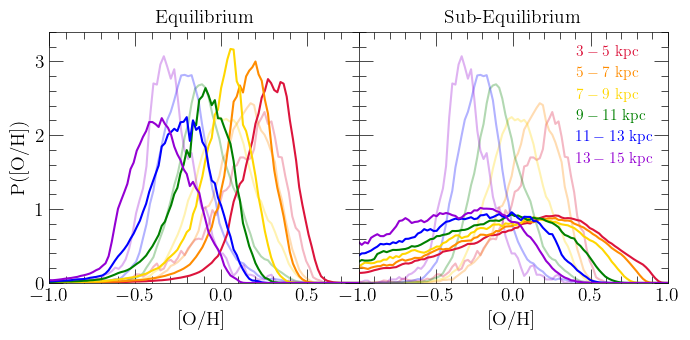

In [7]:
ELEMENT = "O"
RADIAL_BINS = [3, 5, 7, 9, 11, 13, 15]
COLORS = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]
ZONE_WIDTH = 0.1

fig = plt.figure(figsize = (7, 3.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharey = ax1)
for ax in [ax1, ax2]:
    ax.set_xlabel(r"[%s/H]" % (ELEMENT.capitalize()))
ax1.set_ylabel(r"P([%s/H])" % (ELEMENT.capitalize()))
plt.setp(ax2.get_yticklabels(), visible = False)
ax1.set_xlim([-1, 0.8])
ax1.set_ylim([0, 3.4])
ax1.set_yticks([0, 1, 2, 3])
ax2.set_xlim([-1, 1])
ax1.set_title("Equilibrium")
ax2.set_title("Sub-Equilibrium")

raw = np.genfromtxt("./empirical/%sh-dists.out" % (ELEMENT.lower()))
for i in range(len(RADIAL_BINS) - 1):
    xvals = []
    yvals = []
    for j in range(len(raw)):
        if abs(raw[j][0] - RADIAL_BINS[i]) < 0.1:
            xvals.append(raw[j][2])
            yvals.append(raw[j][3])
        else: pass
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "alpha": 0.3
    }
    ax1.plot(xvals, yvals, **kwargs)
    ax2.plot(xvals, yvals, **kwargs)

for stars, ax in [[eq_stars, ax1], [subeq_stars, ax2]]:
    xvals = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
    for i in range(len(RADIAL_BINS) - 1):
        sys.stdout.write("\ri = %d    " % (i))
        sub = stars.filter(
            "zone_final", ">=", int(RADIAL_BINS[i] / ZONE_WIDTH)).filter(
            "zone_final", "<=", int(RADIAL_BINS[i + 1] / ZONE_WIDTH) - 1)
        # dist = boxcarsmoothdist(sub["[%s/h]" % (ELEMENT.lower())], xvals, 0.03)
        dist = boxcarsmoothdist(sub, xvals, 0.03, "[%s/h]" % (ELEMENT.lower()), "mass")
        kwargs = {
            "c": named_colors()[COLORS[i]],
            "label": r"$%d - %d$ kpc" % (RADIAL_BINS[i], RADIAL_BINS[i + 1])
        }
        ax.plot(xvals, dist, **kwargs)
    sys.stdout.write("\n")

kwargs = {
    "loc": mpl_loc("upper right"),
    "columnspacing": 1,
    "handlelength": 0,
    "ncol": 1,
    "fontsize": 11
}
leg = ax2.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(wspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./eq-vs-subeq/%sh-dists-datacomp.%s" % (ELEMENT.lower(), ext), **kwargs)
plt.show()

i = 9    
i = 9    


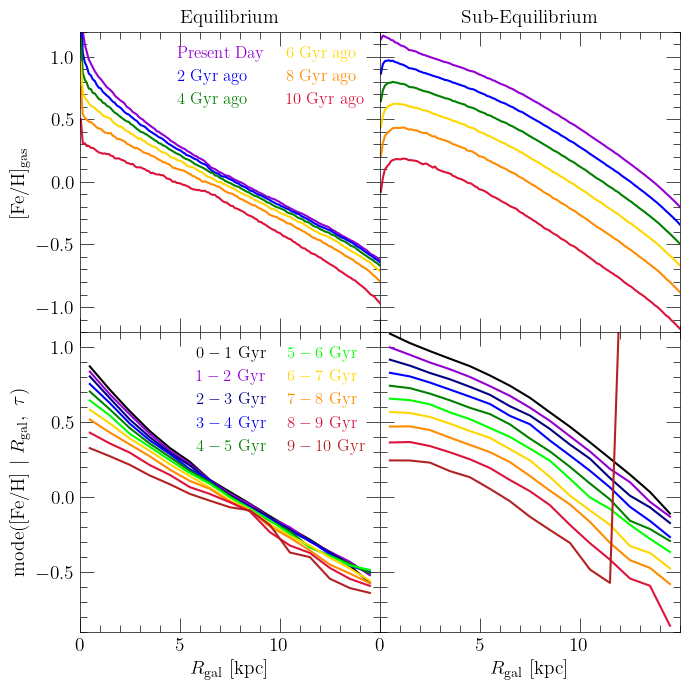

In [72]:
ELEMENT = "fe"
ZONE_WIDTH = 0.1
GAS_SNAPSHOTS = [0, 2, 4, 6, 8, 10]
GAS_COLORS = ["darkviolet", "blue", "green", "gold", "darkorange", "crimson"]
RADIAL_BINS = list(range(16))
AGE_BINS = list(range(11))
STAR_COLORS = ["black", "darkviolet", "navy", "blue", "green", "lime", "gold", "darkorange", "crimson", "firebrick"]

fig = plt.figure(figsize = (7, 7))
axes = []
for i in range(4):
    kwargs = {}
    if i: kwargs["sharex"] = axes[0]
    if i % 2: kwargs["sharey"] = axes[i - 1]
    axes.append(fig.add_subplot(221 + i, **kwargs))
    if i % 2:
        plt.setp(axes[i].get_yticklabels(), visible = False)
    else: pass
    if i < 2:
        plt.setp(axes[i].get_xticklabels(), visible = False)
    else:
        axes[i].set_xlabel(r"$R_\text{gal}$ [kpc]")
    axes[i].set_xlim([0, 15])
    axes[i].set_xticks([0, 5, 10])
axes[0].set_ylabel(r"[%s/H]$_\text{gas}$" % (ELEMENT.capitalize()))
axes[2].set_ylabel(r"mode([%s/H] $|\ R_\text{gal},\ \tau$)" % (ELEMENT.capitalize()))
axes[0].set_ylim([-1.2, 1.2])
axes[0].set_yticks([-1, -0.5, 0, 0.5, 1])
axes[2].set_ylim([-0.9, 1.1])
axes[2].set_yticks([-0.5, 0, 0.5, 1])
axes[0].set_title("Equilibrium")
axes[1].set_title("Sub-Equilibrium")

for output, ax in [[eq, axes[0]], [subeq, axes[1]]]:
    radii = [ZONE_WIDTH * (i + 0.5) for i in range(len(output.zones.keys()))]
    for i in range(len(GAS_SNAPSHOTS)):
        lookback = output.zones["zone0"].history["lookback"]
        diff = [abs(_ - GAS_SNAPSHOTS[i]) for _ in lookback]
        idx = diff.index(min(diff))
        gas = []
        for j in range(len(output.zones.keys())): gas.append(
            output.zones["zone%d" % (j)].history["[%s/h]" % (ELEMENT)][idx])
        kwargs = {"c": named_colors()[GAS_COLORS[i]]}
        if GAS_SNAPSHOTS[i]:
            kwargs["label"] = "%d Gyr ago" % (GAS_SNAPSHOTS[i])
        else:
            kwargs["label"] = "Present Day"
        ax.plot(radii, gas, **kwargs)

for stars, ax in [[eq_stars, axes[2]], [subeq_stars, axes[3]]]:
    centers = [(a + b) / 2 for a, b in zip(RADIAL_BINS[:-1], RADIAL_BINS[1:])]
    for i in range(len(AGE_BINS) - 1):
        sys.stdout.write("\ri = %d    " % (i))
        yvals = []
        sub = stars.filter(
            "age", ">=", AGE_BINS[i]).filter(
            "age", "<=", AGE_BINS[i + 1])
        for j in range(len(RADIAL_BINS) - 1):
            subsub = sub.filter(
                "zone_final", ">=", int(RADIAL_BINS[j] / ZONE_WIDTH)).filter(
                "zone_final", "<=", int(RADIAL_BINS[j + 1] / ZONE_WIDTH) - 1)
            yvals.append(skewnormal_mode_sample(subsub["[%s/h]" % (ELEMENT.lower())]))
        kwargs = {
            "c": named_colors()[STAR_COLORS[i]],
            "label": r"$%d - %d$ Gyr" % (AGE_BINS[i], AGE_BINS[i + 1])
        }
        ax.plot(centers, yvals, **kwargs)
    sys.stdout.write("\n")

kwargs = {
    "loc": mpl_loc("upper right"),
    "columnspacing": 1,
    "handlelength": 0,
    "ncol": 2,
    "fontsize": 12
}
leg = axes[0].legend(**kwargs)
fancy_legend(leg, GAS_COLORS)

leg = axes[2].legend(**kwargs)
fancy_legend(leg, STAR_COLORS)

plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./eq-vs-subeq/%sh-gradients-gas-and-stars.%s" % (ELEMENT.lower(), ext), **kwargs)
plt.show()

8 - 9 Gyr    
8 - 9 Gyr    
8 - 9 Gyr    
8 - 9 Gyr    


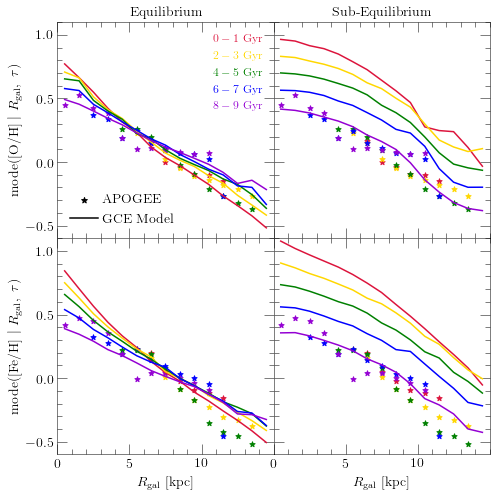

In [5]:
# ELEMENT = "Fe"
RADIAL_BINS = list(range(16))
# RADIAL_BINS = list(range(0, 16, 2))
AGE_RANGES = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
COLORS = ["crimson", "gold", "green", "blue", "darkviolet"]
ZONE_WIDTH = 0.1

fig = plt.figure(figsize = (7, 7))
axes = []
for i in range(4):
    axes.append(fig.add_subplot(221 + i))
    if i > 1:
        axes[i].set_xlabel(r"$R_\text{gal}$ [kpc]")
    else:
        plt.setp(axes[i].get_xticklabels(), visible = False)
    if not i % 2:
        axes[i].set_ylabel(r"mode([%s/H] $|\ R_\text{gal},\ \tau$)" % ({0: "O", 2: "Fe"}[i]))
    else:
        plt.setp(axes[i].get_yticklabels(), visible = False)
    axes[i].set_xlim([0, 15])
    axes[i].set_xticks([0, 5, 10])
    axes[i].set_ylim([-0.6, 1.1])
    axes[i].set_yticks([-0.5, 0, 0.5, 1])
axes[0].set_title("Equilibrium")
axes[1].set_title("Sub-Equilibrium")

star = axes[0].scatter([-1, -2], [-1, -2], c = named_colors()["black"], marker = markers()["star"], label = "APOGEE")
line = axes[0].plot([-1, -2], [-1, -2], c = named_colors()["black"], label = "GCE Model")[0]
kwargs = {"loc": mpl_loc("lower left")}
leg = axes[0].legend(**kwargs)
axes[0].add_artist(leg)
star.remove()
line.remove()

def plot_data(ax, element, filename = "./empirical/skewnormfits-binned-by-age-and-radius.out"):
    raw = np.genfromtxt(filename)
    for i, age_range in enumerate(AGE_RANGES):
        xvals = []
        yvals = []
        for row in raw:
            if row[0] == age_range[0] and row[1] == age_range[1]:
                xvals.append((row[2] + row[3]) / 2)
                yvals.append(row[4 + 2 * int(element.lower() == "fe")])
            else: pass
        kwargs = {
            "c": named_colors()[COLORS[i]],
            "marker": markers()["star"],
            "s": 30
        }
        ax.scatter(xvals, yvals, **kwargs)

def plot_model(ax, element, stars):
    for i, age_range in enumerate(AGE_RANGES):
        sys.stdout.write("\r%d - %d Gyr    " % (age_range[0], age_range[1]))
        xvals = []
        yvals = []
        for j in range(len(RADIAL_BINS) - 1):
            sub = stars.filter(
                "zone_final", ">=", int(RADIAL_BINS[j] / ZONE_WIDTH)).filter(
                "zone_final", "<=", int(RADIAL_BINS[j + 1] / ZONE_WIDTH) - 1).filter(
                "age", ">=", age_range[0]).filter(
                "age", "<=", age_range[1]).filter(
                "mass", ">=", 1)
            xvals.append((RADIAL_BINS[j] + RADIAL_BINS[j + 1]) / 2)
            try:
                yvals.append(skewnormal_mode_sample(sub["[%s/h]" % (element)], weights = sub["mass"]))
            except RuntimeError:
                yvals.append(float("nan"))
        kwargs = {
            "c": named_colors()[COLORS[i]],
            "label": r"$%d - %d$ Gyr" % (age_range[0], age_range[1])
        }
        ax.plot(xvals, yvals, **kwargs)
    sys.stdout.write("\n")

for ax in axes[:2]: plot_data(ax, "O")
for ax in axes[2:]: plot_data(ax, "Fe")
plot_model(axes[0], "O", eq_stars)
plot_model(axes[1], "O", subeq_stars)
plot_model(axes[2], "Fe", eq_stars)
plot_model(axes[3], "Fe", subeq_stars)
# plot_model(ax1, eq_stars)
# plot_model(ax2, subeq_stars)

kwargs = {
    "loc": mpl_loc("upper right"),
    "ncol": 1,
    "handlelength": 0,
    "columnspacing": 1,
    "fontsize": 12
}
leg = axes[0].legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./eq-vs-subeq/grad-xh-vs-apogee.%s" % (ext))
plt.show()